In previous posts, I looked at how to discretize the incompressible Stokes equations.
The Stokes equations are a good approximation when the fluid speed is small enough that inertial effects are negligible.
The relevant dimensionless number is the ratio
$$\text{Re} = \frac{\rho UL}{\mu},$$
the Reynolds number.
Stokes flow applies when the Reynolds number is substantially less than 1.
The incompressibility constraint adds a new difficulty: we have to make good choices of finite element bases for the velocity and pressure.
If we fail to do that, the resulting linear systems can have no solution or infinitely many.

Here I'll look at how we can discretize the full Navier-Stokes equations:
$$\frac{\partial}{\partial t}\rho u + \nabla\cdot\rho u\otimes u = -\nabla p + \nabla\cdot \tau$$
where the deviatoric stress tensor is $\tau = 2\mu\dot\varepsilon$.
The inertial terms are nonlinear, which makes this problem more difficult yet than the Stokes equations.

The goal here will be to simulate the famous [von Kármán vortex street](https://en.wikipedia.org/wiki/K%C3%A1rm%C3%A1n_vortex_street).

### Making the initial geometry

First, we'll make a domain consisting of a circle punched out of a box.
The fluid flow in the wake of the circle will produce vortices.

In [1]:
import gmsh
gmsh.initialize()

In [2]:
import numpy as np
from numpy import pi as π

Lx = 6.0
Ly = 2.0
lcar = 1 / 16

gmsh.model.add("chamber")
geo = gmsh.model.geo
ps = [(0, 0), (Lx, 0), (Lx, Ly), (0, Ly)]
box_points = [geo.add_point(*p, 0, lcar) for p in ps]
box_lines = [
    geo.add_line(i1, i2) for i1, i2 in zip(box_points, np.roll(box_points, 1))
]

for line in box_lines:
    geo.add_physical_group(1, [line])

f = 1 / 3
c = np.array([f * Lx, Ly / 2, 0])
center = geo.add_point(*c)
r = Ly / 8
num_circle_points = 16
θs = np.linspace(0.0, 2 * π, num_circle_points + 1)[:-1]
ss = np.column_stack((np.cos(θs), np.sin(θs), np.zeros(num_circle_points)))
tie_points = [geo.add_point(*(c + r * s), lcar) for s in ss]
circle_arcs = [
    geo.add_circle_arc(p1, center, p2)
    for p1, p2 in zip(tie_points, np.roll(tie_points, 1))
]

geo.add_physical_group(1, circle_arcs)

outer_curve_loop = geo.add_curve_loop(box_lines)
inner_curve_loop = geo.add_curve_loop(circle_arcs)
plane_surface = geo.add_plane_surface([outer_curve_loop, inner_curve_loop])
geo.add_physical_group(2, [plane_surface])
geo.synchronize()

In [3]:
gmsh.model.mesh.generate(2)
gmsh.write("chamber.msh")

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 20%] Meshing curve 3 (Line)
Info    : [ 20%] Meshing curve 4 (Line)
Info    : [ 30%] Meshing curve 5 (Circle)
Info    : [ 30%] Meshing curve 6 (Circle)
Info    : [ 40%] Meshing curve 7 (Circle)
Info    : [ 40%] Meshing curve 8 (Circle)
Info    : [ 50%] Meshing curve 9 (Circle)
Info    : [ 50%] Meshing curve 10 (Circle)
Info    : [ 60%] Meshing curve 11 (Circle)
Info    : [ 60%] Meshing curve 12 (Circle)
Info    : [ 70%] Meshing curve 13 (Circle)
Info    : [ 70%] Meshing curve 14 (Circle)
Info    : [ 80%] Meshing curve 15 (Circle)
Info    : [ 80%] Meshing curve 16 (Circle)
Info    : [ 90%] Meshing curve 17 (Circle)
Info    : [ 90%] Meshing curve 18 (Circle)
Info    : [100%] Meshing curve 19 (Circle)
Info    : [100%] Meshing curve 20 (Circle)
Info    : Done meshing 1D (Wall 0.00222713s, CPU 0.003227s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delau

In [4]:
import firedrake
mesh = firedrake.Mesh("chamber.msh")

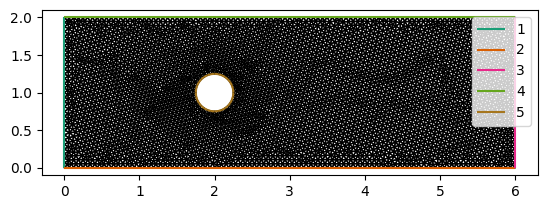

In [5]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.set_aspect("equal")
firedrake.triplot(mesh, axes=ax)
ax.legend(loc="upper right");

### Initial velocity

We'll use a fixed inflow velocity
$$u_x = 4 \frac{y}{L_y}\left(1 - \frac{y}{L_y}\right) u_{\text{in}}.$$
We'll take as characteristic length scale the radius of the disc $L_y / 8$.
In order to see the effect we want, we'll need a Reynolds number that's on the order of 100 or greater.

In [6]:
from firedrake import Constant

μ = Constant(1e-2)

x, y = firedrake.SpatialCoordinate(mesh)
u_in = Constant(5.0)
ly = Constant(Ly)
expr = firedrake.as_vector((4 * u_in * y / ly * (1 - y / ly), 0))

I've used Taylor-Hood elements for this demonstration.
It would be a good exercise to repeat this using, say, Crouzeix-Raviart or other elements.

In [7]:
cg1 = firedrake.FiniteElement("CG", "triangle", 1)
cg2 = firedrake.FiniteElement("CG", "triangle", 2)
Q = firedrake.FunctionSpace(mesh, cg1)
V = firedrake.VectorFunctionSpace(mesh, cg2)
Z = V * Q
z = firedrake.Function(Z)

Here we can use the fact that the Stokes problem has a minimization form.
The Navier-Stokes equations do not because of the convective term.

In [8]:
from firedrake import inner, sym, grad, div, dx, ds

u, p = firedrake.split(z)
ε = lambda v: sym(grad(v))

L = (μ * inner(ε(u), ε(u)) - p * div(u)) * dx

inflow_ids = (1,)
outflow_ids = (3,)
side_wall_ids = (2, 4, 5)
side_wall_bcs = firedrake.DirichletBC(Z.sub(0), Constant((0.0, 0.0)), side_wall_ids)
inflow_bcs = firedrake.DirichletBC(Z.sub(0), expr, inflow_ids)
bcs = [side_wall_bcs, inflow_bcs]

F = firedrake.derivative(L, z)
firedrake.solve(F == 0, z, bcs)

A bit of a philosophical point is in order here.
We picked the inflow velocity and the viscosity to produce a high Reynolds number (about 200).
The Stokes equations, on the other hand, are physically realistic only when the Reynolds number is $\ll 1$.
But we can still solve the Stokes equations in the high-Reynolds number limit.
In other words, the mathematical model remains well-posed even in regimes where it is not applicable.
Here we're only using the result to initialize a simulation using the "right" model.
But it's a mistake -- and one I've made -- to lull yourself into a false sense of correctness merely because the model gave you an answer.

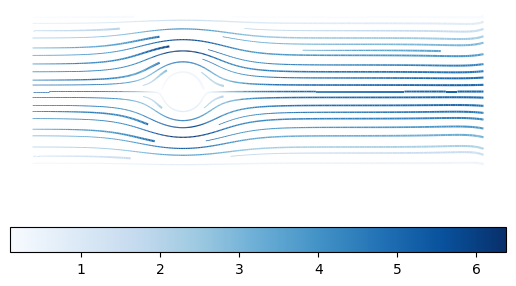

In [9]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.set_axis_off()
colors = firedrake.streamplot(
    z.subfunctions[0], resolution=1/16, seed=1729, cmap="Blues", axes=ax
)
fig.colorbar(colors, orientation="horizontal");

### Solution method

There are a host of methods for solving the Navier-Stokes equations by breaking them up into two simpler problems.
These are known as [projection methods](https://en.wikipedia.org/wiki/Projection_method_(fluid_dynamics)).
I started out trying those but it required effort, which I find disgusting.
So I threw backward Euler at it and it worked.

There are some non-trivial decisions to make about both the variational form and the boundary conditions.
I started writing this wanting to use pressure boundary conditions at both the inflow and outflow.
(Of course I had to [be reminded](https://scicomp.stackexchange.com/questions/35928/imposing-pressure-variation-instead-of-dirichlet-boundary-conditions-on-finite-e) that you can't prescribe pressures but rather tractions.)
This went badly.
If a wave reflects off of the obstacle, back upstream, and out the inflow boundary, the simulation will crash.
So I had to dial back the challenge and use a fixed inflow velocity and a traction boundary condition at the outflow.

Almost any writing you see about the Navier-Stokes equations will express the problem in differential form and will use incompressibility to apply what might appear to be simplifications.
For example, if the fluid is incompressible and the viscosity is constant, then you can rewrite the viscous term like so:
$$\nabla\cdot \mu(\nabla u + \nabla u^\top) = \mu\nabla^2u.$$
You'll see this form in almost all numerical methods or engineering textbooks.
I don't like it for two reasons.
First, the apparent simplification only gets in your way as soon as you want to consider fluids with variable viscosity.
Mantle convection is one obvious case -- the temperature and chemistry of mantle rock can change the viscosity by several orders of magnitude.
Second, it gives the wrong boundary conditions when you try to discretize the problem (see [Limache et al. (2007)](https://doi.org/10.1002/fld.1480)).
I've retained the symmetric gradients of the velocity and test function in the form below.

The second apparent simplification uses incompressibility to rewrite the convection term:
$$\nabla\cdot \rho u\otimes u = u\cdot\nabla \rho u.$$
This form is ubiquitous and reflects a preference for thinking about fluid flow in a Lagrangian reference frame.
I prefer to avoid it although both are correct, unlike the Laplacian form of the viscosity.
Given any extensive density $\phi$, regardless of its tensor rank, the flux will include a term $\phi\cdot u$.
The conversion of this flux from the conservation to the variational form is then
$$-\int_\Omega \phi u\cdot\nabla\psi\,dx$$
and this is true of mass, momentum, energy, whatever you like.
Taking something that was a divergence and making it not a divergence obfuscates the original conservation principle.
It also stops you from pushing the differential operator over onto a test function.
So I've instead coded up the convection term as a discretization of
$$-\int_\Omega u\otimes u\cdot\dot\varepsilon(v)\,dx + \int_{\partial\Omega\cap\{u\cdot n \ge 0\}}(u\cdot n)(v\cdot n)ds.$$
In the first term, I've used the symmetric gradient of $v$ because the contraction of a symmetric and an anti-symmetric tensor is zero.

All together now, the variational form that I'm using is
$$\begin{align}
0 & = \int_\Omega\left\{\rho\,\partial_tu\cdot v - \rho u\otimes u:\varepsilon(v) - p\nabla\cdot v - q\nabla\cdot u + 2\mu\,\dot\varepsilon(u):\dot\varepsilon(v)\right\}dx \\
& \qquad\qquad + \int_\Gamma (\rho u\cdot n)(u \cdot v)ds.
\end{align}$$
for all test functions $v$ and $q$.

In [10]:
from firedrake import outer
from irksome import Dt

v, q = firedrake.TestFunctions(Z)
u, p = firedrake.split(z)

ρ = firedrake.Constant(1.0)

F_1 = (
    ρ * inner(Dt(u), v) -
    ρ * inner(ε(v), outer(u, u)) -
    p * div(v) -
    q * div(u) +
    2 * μ * inner(ε(u), ε(v))
) * dx

n = firedrake.FacetNormal(mesh)
F_2 = ρ * inner(u, v) * inner(u, n) * ds(outflow_ids)

F = F_1 + F_2

We'll need to make some choice about the timestep.
Here I've computed the CFL time for the mesh and the initial velocity that we computed above.
This choice might not be good enough.
If we initialized the velocity by solving the Stokes equations, the fluid could evolve to a much higher speed.
We might then find that this timestep is inadequate.
A principled solution would be to use an adaptive scheme.

In [11]:
dg0 = firedrake.FiniteElement("DG", "triangle", 0)
Δ = firedrake.FunctionSpace(mesh, dg0)
area = firedrake.Function(Δ).project(firedrake.CellVolume(mesh))
δx_min = np.sqrt(2 * area.dat.data_ro.min())

u, p = z.subfunctions
U_2 = firedrake.Function(Δ).project(inner(u, u))
u_max = np.sqrt(U_2.dat.data_ro.max())
cfl_time = δx_min / u_max
print(f"Smallest cell diameter: {δx_min:0.4f}")
print(f"Max initial velocity:   {u_max:0.4f}")
print(f"Timestep:               {cfl_time:0.4f}")

dt = firedrake.Constant(0.5 * cfl_time)

Smallest cell diameter: 0.0351
Max initial velocity:   6.4170
Timestep:               0.0055


In [12]:
import irksome

params = {
    "solver_parameters": {
        "snes_monitor": ":navier-stokes-output.log",
        "snes_atol": 1e-12,
        "ksp_atol": 1e-12,
        "snes_type": "newtonls",
        "ksp_type": "gmres",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
    },
    "bcs": bcs,
}

method = irksome.BackwardEuler()
t = firedrake.Constant(0.0)
solver = irksome.TimeStepper(F, method, t, dt, z, **params)

I've added a bit of code to show some diagnostic information in the progress bar.
First I have it printing out the number of Newton iterations that were required to compute each timestep.
If you see this going much above 20 then something is off.
Second, I had it print out the maximum pressure.
Both of these were useful when I was debugging this code.

In [13]:
from tqdm.notebook import trange

zs = [z.copy(deepcopy=True)]

final_time = 10.0
num_steps = int(final_time / float(dt))
progress_bar = trange(num_steps)
for step in progress_bar:
    solver.advance()
    zs.append(z.copy(deepcopy=True))
    iter_count = solver.solver.snes.getIterationNumber()
    pmax = z.subfunctions[1].dat.data_ro.max()
    progress_bar.set_description(f"{iter_count}, {pmax:0.4f} | ")

  0%|          | 0/3654 [00:00<?, ?it/s]

Finally, we'll make an animated quiver plot because it looks pretty.

In [14]:
%%capture

from tqdm.notebook import tqdm
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.set_axis_off()

X = mesh.coordinates.dat.data_ro
V = mesh.coordinates.function_space()
u_t = zs[0].subfunctions[0].copy(deepcopy=True)
interpolator = firedrake.Interpolate(u_t, V)
u_X = firedrake.assemble(interpolator)
u_values = u_X.dat.data_ro

arrows = firedrake.quiver(zs[0].subfunctions[0], axes=ax, cmap="Blues")
def animate(z):
    u_t.assign(z.subfunctions[0])
    u_X = firedrake.assemble(interpolator)
    u_values = u_X.dat.data_ro
    arrows.set_UVC(*(u_values.T))

animation = FuncAnimation(fig, animate, tqdm(zs), interval=1e3/60)

In [15]:
from IPython.display import HTML
HTML(animation.to_html5_video())

There's an [empirical formula](https://en.wikipedia.org/wiki/K%C3%A1rm%C3%A1n_vortex_street#Formula) for the frequency of vortex shedding.
A fun follow-up to this would be to compute the shedding frequency from the simulation using, say, a windowed Fourier transform, and comparing the result to the empirical formula.
Next on the docket is comparing the results using different spatial finite elements.